# 題目:
## 使用RNN-LSTM搭配葛蘭傑因果分析於軸承錯誤之定位

# 方法:
## 使用pytorch 建立RNN-LSTM模型，來預測震動訊號，並用預測結果來計算因果性，觀察四個軸承的因果性隨時間的改變，找出哪個軸承損壞以及損害的時間點

## Input: 四個軸承訊號，取樣率為20kHz，每十分鐘取20480個點，共有984筆資料
## Output: 軸承間的Causality值

## 葛蘭傑因果分析(Granger Causality)方法簡介
Time Domain Granger Causality:<br/>
假設X, Y是兩個平穩(Stationary)的時間序列，則X,Y可以利用以下的自回歸模型(Auto regression Model)來加以表示：<br/>
$$\tag{1}\begin{pmatrix}X_t\\\\Y_t\end{pmatrix}=
 \sum_{k=1}^p
 \begin{pmatrix}A_{xx,k} & A_{xy,k}\\\\A_{yx,k} & A_{yy,k}\end{pmatrix}
 \begin{pmatrix}X_{t-k}\\\\Y_{t-k}\end{pmatrix}+
 \begin{pmatrix}\varepsilon_{x,t}\\\\\varepsilon_{y,t}\end{pmatrix}$$
其中，係數矩陣$A_{xx}, A_{xy}, A_{yx},A_{yy}$ 必須滿足以下平方可加性(Square Summability)以及穩定性(Stablility)的需求，如方程式(2)-(3)所示：<br/>
$$\tag{2}\sum_{k=1}^p\begin{Vmatrix}A_{\bullet,k}\end{Vmatrix}<\infty$$
$$\tag{3}\varphi_A(z)\equiv\left|\begin{matrix}I-\sum_{k=1}^pA_kz^k\end{matrix}\right|\qquad\qquad\ 
\rho(A)\equiv max\{|Z|^{-1}\}\rho(A)<1$$
方程式(1)中的X可以表示成
$$\tag{4}X_t=\sum_{k=1}^pA_{xx,k}\centerdot X_{t-k}+\sum_{k=1}^pA_{xy,k}\centerdot Y_{t-k}+\varepsilon_{x,t}$$
若去除Y對X的影響，也就是令$A_{xy,1}=A_{xy,2}=\centerdot\centerdot\centerdot A_{xy,p}=0，則$
$$\tag{5}X_t=\sum_{k=1}^pA_{xx,k}^{'}\centerdot X_{t-k}+\varepsilon_{x,t}^{'}$$
Y 到 X 的 Granger Causality 
$$\tag{6}F_{Y\to X}\equiv ln\frac{|Cov(\varepsilon_{x,t}^{'})|}{|Cov(\varepsilon_{x,t})|}=ln\frac{\sum_{xx}^{'}}{\sum_{xx}}$$
根據方程式(4)-(6)，我們可以了解 Granger Causality的精神：若加入Y的過去值，可以增加預測 X 現在值的準確度，也就是
$Cov(\varepsilon_{x,t})< Cov(\varepsilon_{x,t}^{'})$，則稱為 Y Granger Cause X。當Y對X現在值的預測值越有幫助，$Cov(\varepsilon_{x,t})$越小，$F_{Y\to X}$ 值則越大。

## 本程式的演算法:
步驟一：假設現有四組訊號Ch1、Ch2、Ch3、Ch4，將四組訊號的資料分成和驗證用訓練、驗證、測試訊號。輸入訓練用的訊號後，訓練出最佳的LSTM 模型，並由驗證用的訊號進行驗證。<br/>

步驟二：將四組訊號的過去資料(t-x)丟入LSTM 模型，並用模型預測訊號的現在資料(t)，和真正的現在資料比對，計算誤差值。<br/>

步驟三：分別移除 Ch1、Ch2、Ch3、Ch4，重複步驟二，計算誤差值。假設移除Ch1，會導致預測Ch2失準，誤差之變異數增大，則可以判定Ch1對Ch2具有因果性。<br/>

步驟四: 將各個誤差去變異數後，有拔掉channel的變異數除以沒拔掉的後再取ln<br/>
## Example:<br/>
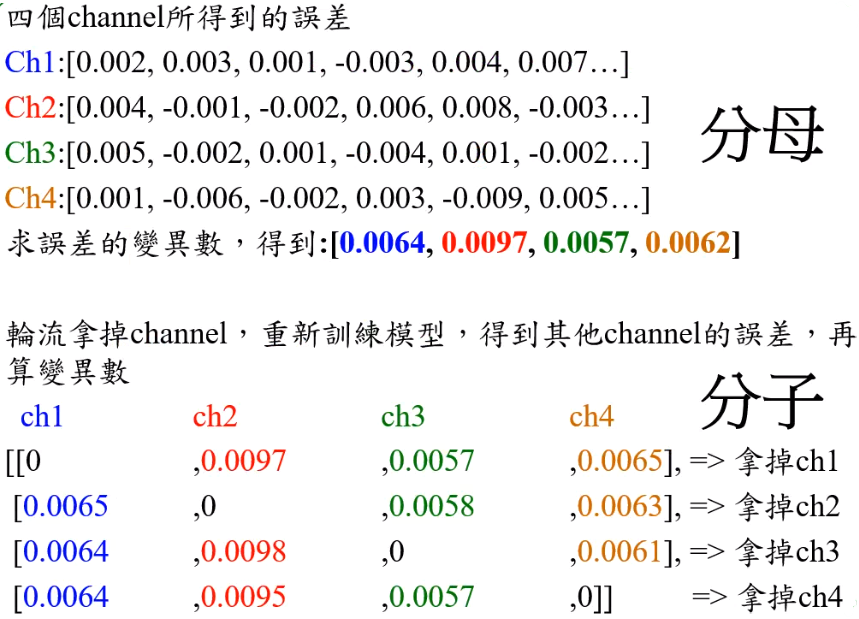
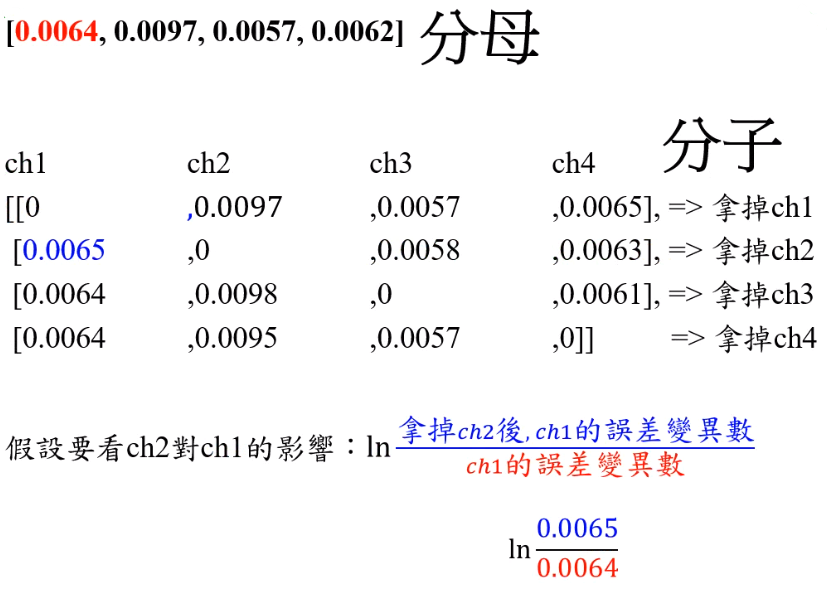

資料來源:http://data-acoustics.com/measurements/bearing-faults/bearing-4/<br/>
參考資料:https://ieeexplore.ieee.org/document/8370751<br/>

## 進度
5/8  資料前處理<br/>
5/15 建立模型<br/>
5/22 自訂差分方程式驗證模型<br/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from torch import nn, optim
#呼叫自己的套件
from core import (Timer, get_Granger_Causality, get_json_data, get_mat_data, make_loader, matshow, set_device)
from Models import Modeler, RNN_Net

# 訓練以及驗證

In [2]:
def train_valid(in_dim, hidden_dim, out_dim, ckpt, test_data, loaders):
    #建立model
    net = RNN_Net(in_dim, hidden_dim, out_dim, rnn_type=cfg['rnn_type'], 
                  num_layers=cfg['num_layers'], dropout=cfg['dropout'])
    opt = optim.RMSprop(net.parameters(), lr=cfg['lr_rate'],
                        momentum=cfg['momentum'],
                        weight_decay=cfg['weight_decay'])
    lr_decay2 = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)
    criterion = nn.MSELoss()
    model = Modeler(net, opt, criterion, device)
    
    t_loss = []
    v_loss = []
    
    for epoch in range(cfg['num_epoch']):
        train_loss = model.train_model(loaders['train'])
        t_loss.append(train_loss)
        valid_loss = model.evaluate_model(loaders['valid'])
        v_loss.append(valid_loss)
        lr_decay2.step(valid_loss)
        print(f"[{epoch+1}/{cfg['num_epoch']}] ===>> train_loss: {train_loss: .4f} | valid_loss: {valid_loss: .4f}")
     
    #畫loss的趨勢圖
    t_loss = np.array(t_loss)
    v_loss = np.array(v_loss)
    x = np.linspace(1,cfg['num_epoch'],cfg['num_epoch'])
    plt.figure(dpi=200)
    plt.plot(x, t_loss, color = "blue")
    plt.plot(x, v_loss, color = "orange")
    plt.legend(["train_loss","valid_loss"])
    plt.grid()
    plt.savefig(ckpt+'.png')
    plt.close()    
        
    model.save_trained_model(ckpt+'.pth')
    model.load_model(ckpt+'.pth')
    prediction, err = model.predict(*test_data)
    
    #預測結果視覺化
    for ch in range(prediction.shape[-1]):
        plt.figure(dpi=200)
        plt.plot(np.c_[test_data[1].cpu().numpy()[:,ch]], color = "blue")
        plt.plot(np.c_[prediction.cpu().numpy()[:,ch]], color = "red")
        plt.ylim([0,1])
        plt.legend([f'label channel{ch+1}',f'prediction channel{ch+1}'])
        plt.grid()
        plt.savefig(f'images/{signal_type}/prediction/{signal_type}{(i+1)*10}_err{ch}'+time.strftime('%Y_%m_%d_%H_%M_%S')+'.png')
        plt.close()
        plt.figure(dpi=200)
        plt.plot(np.c_[err.cpu().numpy()[:,ch]], '.', color = "green")
        plt.ylim([-1,1])
        plt.legend([f'err{ch+1}, var={err[:,ch].double().cpu().numpy().var(): .4f}'])
        plt.grid()
        plt.tight_layout()
        plt.savefig(f'images/{signal_type}/error/{signal_type}{(i+1)*10}_err{ch}'+time.strftime('%Y_%m_%d_%H_%M_%S')+'.png')
        plt.close()
    
    return err

In [3]:
def main(s_number):
    #讀取資料
    if signal_type in all_signal_type[:3]:
        seq_data_all = get_mat_data(f'Data/{signal_type}_noise1.mat', f'{signal_type}')
    else:
        seq_data_all = get_mat_data(f'Data/{signal_type}/{signal_type}{s_number}.mat', f'{signal_type}')
    
    model_id = 1
    print(f'model_id: {model_id}')
    #將資料分成訓練、驗證、測試集
    train_loader, valid_loader, test_loader = make_loader(
            seq_data_all, tt_split=cfg['tt_split'], tv_split=cfg['tv_split'],
            seq_len=cfg['seq_len'], bt_sz=cfg['bt_sz'])
    loaders = {'train':train_loader, 'valid': valid_loader}
    #未拔掉任何channel的誤差值(err_all)
    err_all = train_valid(cfg['in_dim'], cfg['num_hidden'], cfg['out_dim'],
                          f'checkpoints/{signal_type}/{signal_type}{s_number}_model_weights',
                          test_loader.dataset.get_tensor_data(), loaders)
    
    #依序拔掉一個channel來做預測，得到誤差err_cond
    temp = []
    for ch in range(cfg['num_channel']):
        model_id += 1
        print(f'model_id: {model_id}')
        idx = list(set(range(cfg['num_channel'])) - {ch})  
        seq_data = seq_data_all[:, idx]
        train_loader, valid_loader, test_loader = make_loader(
            seq_data, tt_split=cfg['tt_split'], tv_split=cfg['tv_split'],
            seq_len=cfg['seq_len'], bt_sz=cfg['bt_sz'])
        loaders = {'train':train_loader, 'valid': valid_loader}
        err = train_valid(cfg['in_dim']-1, cfg['num_hidden'], cfg['out_dim']-1,
                          f'checkpoints/{signal_type}/{signal_type}{s_number}_model_weights',
                          test_loader.dataset.get_tensor_data(), loaders) 
        temp += [err]
    temp = torch.stack(temp)
    
    err_cond = temp.new_zeros(temp.size(0), temp.size(1), cfg['num_channel'])
    for idx in range(cfg['num_channel']):
        col = list(set(range(cfg['num_channel'])) - {idx})
        err_cond[idx, :, col] = temp[idx]
    return get_Granger_Causality(err_cond, err_all)

In [8]:
#決定存檔名字
flag = 0

signal type: linear_signals
model_id: 1
[1/15] ===>> train_loss:  0.0052 | valid_loss:  0.0100
[2/15] ===>> train_loss:  0.0045 | valid_loss:  0.0049
[3/15] ===>> train_loss:  0.0041 | valid_loss:  0.0046
[4/15] ===>> train_loss:  0.0040 | valid_loss:  0.0043
[5/15] ===>> train_loss:  0.0040 | valid_loss:  0.0041
[6/15] ===>> train_loss:  0.0040 | valid_loss:  0.0040
[7/15] ===>> train_loss:  0.0039 | valid_loss:  0.0039
[8/15] ===>> train_loss:  0.0039 | valid_loss:  0.0038
[9/15] ===>> train_loss:  0.0040 | valid_loss:  0.0038
[10/15] ===>> train_loss:  0.0040 | valid_loss:  0.0037
[11/15] ===>> train_loss:  0.0040 | valid_loss:  0.0037
[12/15] ===>> train_loss:  0.0040 | valid_loss:  0.0037
[13/15] ===>> train_loss:  0.0040 | valid_loss:  0.0037
[14/15] ===>> train_loss:  0.0039 | valid_loss:  0.0037
[15/15] ===>> train_loss:  0.0039 | valid_loss:  0.0036
model_id: 2
[1/15] ===>> train_loss:  0.0062 | valid_loss:  0.0117
[2/15] ===>> train_loss:  0.0058 | valid_loss:  0.0058
[3/15] 

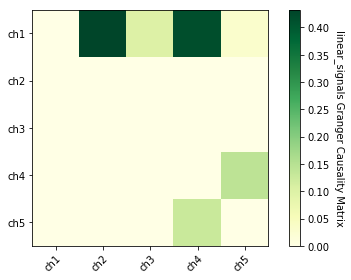

Time taken: 195.27s


In [7]:
if __name__ == '__main__':
    
    for i in range(1):
        
        timer = Timer()
        timer.start()
        #讀入不同種訊號的參數
        config = get_json_data('configs/cfg.json')
        #設定使用 GPU
        device = set_device()
        #訊號種類
        all_signal_type = ['linear_signals', 'nonlinear_signals', 'longlag_nonlinear_signals', 'IMS']
        
        avg_gc_matrix = 0
        
        signal_type = all_signal_type[0]
        print(f'signal type: {signal_type}')
        cfg = config[signal_type]
        for _ in range(cfg['num_trial']):
            avg_gc_matrix += main((i+1)*10)
            
        label = ['ch' + str(t + 1) for t in range(cfg['num_channel'])]
        
        if flag == 1:
            matshow(avg_gc_matrix, label, label, f'{signal_type} Granger Causality Matrix', f'images/{signal_type}/result/{signal_type}{(i+1)*10}_Granger_Matrix'+time.strftime('%Y_%m_%d_%H_%M_%S')+'.png')
            np.savetxt(f'checkpoints/{signal_type}/{signal_type}{(i+1)*10}_granger_matrix.txt', avg_gc_matrix)
        else:
            matshow(avg_gc_matrix, label, label, f'{signal_type} Granger Causality Matrix', f'images/{signal_type}/result/{signal_type}_Granger_Matrix'+time.strftime('%Y_%m_%d_%H_%M_%S')+'.png')
            np.savetxt(f'checkpoints/{signal_type}/{signal_type}_granger_matrix.txt', avg_gc_matrix)

        # 計時结束
        timer.stop() 